In [1]:
# <examples/doc_model_two_components.py>
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt
from lmfit import Model
from lmfit.models import PowerLawModel, ExponentialModel, GaussianModel
from lib.to_precision import to_precision
import lmfit
from sympy import *
import sympy
from sympy.solvers import solve
from sympy import Symbol
import math
import datetime
from ipywidgets import interact, FloatText, IntText, fixed, Text
now = lambda: str(datetime.datetime.now()).replace("-", "").replace(":", "").replace(" ", "_").split(".")[0]
import inspect

In [2]:
# def get_Latex_Func(func):
#     # Get the source code of the function
#     source_lines = inspect.getsource(func).split('\n')

#     # Find the return statement
#     return_line = [line for line in source_lines if 'return' in line][0]

#     # Extract the expression after 'return'
#     expr = return_line.split('return')[1].strip()
    
#     tatex_func = sympy.latex(sympy.sympify(expr))
#     strg = (
#         "\\begin{align} \n \t f(x) = " + tatex_func + "\n" + "\end{align} \n"
#     )
#     return strg


def get_Latex_Func(func):
    # Get the source code of the function
    source_lines = inspect.getsource(func).split('\n')
    
    # Find the return statement
    return_line = [line for line in source_lines if 'return' in line][0].strip()
    
    # Extract the expression after 'return'
    expr = return_line.split('return')[1].strip()
    
    # Extract variable names from the function's signature
    
    sig = inspect.signature(func)
    param_names = list(sig.parameters.keys())
    
    # Create sympy symbols for all parameters
    symbols = sympy.symbols(' '.join(param_names))
    
    # Create a local dictionary of symbols
    local_dict = dict(zip(param_names, symbols))
    
    # Add numpy and math functions to the local dictionary
    local_dict.update({
        'sqrt': sympy.sqrt,
        'exp': sympy.exp,
        'pi': sympy.pi
    })
    
    # Convert the expression to a SymPy expression
    sympy_expr = sympy.parsing.sympy_parser.parse_expr(
        expr.replace('np.', '').replace('math.', ''), 
        local_dict=local_dict
    )
    
    # Convert to LaTeX
    tatex_func = sympy.latex(sympy_expr)
    
    strg = (
        "\\begin{align} \n \t f(" + ", ".join(param_names) + ") = " + tatex_func + "\n" + "\\end{align} \n"
    )
    return strg




def save_data_to_file(filename='data.pkl'):
    # Dictionary für Parameter-Werte erstellen
    data_dict = {"x":Daten.get_x(),"xerr":Daten.get_xerr(),"y":Daten.get_y(),"yerr":Daten.get_yerr(),"XName":Daten.get_XName(),"YName":Daten.get_YName()}
    # Konvertiere alle Numpy-Arrays im Dictionary in Listen
    # dict_serializable = {key: value.tolist() if isinstance(value, np.ndarray) else value 
    #                      for key, value in data_dict.items()}
    # __x = []
    # __y = []
    # __xerr = 0
    # __yerr = 0
    # __XName = "x"
    # __YName = "y"
    # __FileName = "dataset_1"

    # Parameter als JSON-Datei speichern
    with open(filename, 'wb') as f:
        pickle.dump(data_dict, f)
    print(f"Daten wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_data_from_file(filename='params.pkl'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f)
    
    # # Konvertiere Listen zurück in Numpy-Arrays
    # data_dict= {key: np.array(value) if isinstance(value, list) else value
    #                     for key, value in dict_with_arrays.items()}

    # Geladene Werte in die Parameter setzen
    Daten.set_x(data_dict.get("x"))
    Daten.set_xerr(data_dict.get("xerr"))
    Daten.set_y(data_dict.get("y"))
    Daten.set_yerr(data_dict.get("yerr"))
    Daten.set_XName(data_dict.get("XName"))
    Daten.set_YName(data_dict.get("YName"))

    print(f"Daten wurden aus {filename} geladen.")

def finish(x,y,result, string, y_err, yLabel, xLabel, var_func_bool= False):
    fig = plt.figure(figsize=(9,6), dpi=80)
    dynamic_resolution_array = np.arange(min(x),max(x), 0.001*abs(max(x)-min(x)))
    #plt.plot(x, y, 'skyblue')
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.errorbar(
        y = y, 
        x = x, 
        yerr = y_err,
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, label = r'Werte'
        ) #xerr = x_err, yerr = y_err, 
    plt.legend(loc='best')

    plt.ylabel(yLabel, fontsize=20)
    plt.xlabel(xLabel, fontsize=20)

    plt.legend(fontsize=12)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    string += Daten.get_Version()
    fig.savefig(string + "_Fit.pdf")
    plt.show()

    string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{Fits/" + string + "_Fit.pdf} \n" \
        + "\t\\caption{"+str(string)+", Fit} \n \t\\label{fig:"+str(string)+", Fit} \n\end{figure}"
    print(string_fig)

    text_file = open(string+"_params"+".tex", "w+", encoding="utf-8")
    string_fig += "\n \\\\ \n" 
    string_fig += get_Latex_Func(Daten.get_func()) if var_func_bool else ""
    string_fig += table_of_params(result)
    text_file.write(string_fig)
    text_file.close()

def table_of_params(result_of_fit):
    sig_num = 3
    string = "" + (
        "\\begin{table}[ht] \n"
        "\centering \n") +"\caption{" + str(Daten.get_FileName()) +", Fit Parameter Tabelle} \n"  + (
        "\label{tab:my-table}\n"
        "\\begin{tabular}{|l|c|}\n" 
        "\hline\n"
        "Parameter Name\t&\tWert \\\\ \hline\n"
    )
    for i in result_of_fit.params:
        str_param_val = f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}" 
        str_param_std = f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}" 
        string += (
            str(i) + "\t&\t" +
            str_param_val +
            ("" if "." in str_param_val  else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num+2 -len(f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}"))) +
            " \\pm "+ 
            str_param_std +
            ("" if "." in str_param_std else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num+2-len(f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}"))) +
            "\\\\ \hline\n"
        )
    string += (
        "\end{tabular} \n"
        "\end{table}"
    )
    return string


class Data:
    __x = []
    __y = []
    __xerr = 0
    __yerr = 0
    __XName = "x"
    __YName = "y"
    __FileName = "dataset_1",
    __Version = ""
    __pars = None
    __func = None
    
    def set_func(self, x):
        self.__func = x
        return
    def get_func(self):
        return self.__func

    def set_x(self, x):
        self.__x = x
        return  
    def set_y(self, x):
        self.__y = x
        return  
    def set_yerr(self, x):
        self.__yerr = x
        return  
    def set_xerr(self, x):
        self.__xerr = x
        return  
    
    def get_x(self):
        return self.__x
    def get_y(self):
        return self.__y
    def get_xerr(self):
        return self.__xerr
    def get_yerr(self):
        return self.__yerr
    
    def set_XName(self, x):
        self.__XName = rf"{x}"
        return
    def set_YName(self, x):
        self.__YName = rf"{x}"
        return
    def get_XName(self):
        return self.__XName
    def get_YName(self):
        return self.__YName
    
    def get_FileName(self):
        return self.__FileName
    
    def set_FileName(self, x):
        self.__FileName = f"{x}"
        return
    def set_Version(self, x):
        self.__Version = f"{x}"
        return
    def get_Version(self):
        return self.__Version
    
    def get_pars(self):
        return self.__pars
    def set_pars(self,x):
        self.__pars = x
        return

def import_Data(Datei:str="dataset_1", x_err_bool = False, y_err_bool = False, Daten=Data(), skip_lower:str="0", skip_upper:str="0", x_name:str="x", y_name:str="y", save_bool=False,Save:int=0,Load:int=0,switch_axes:bool=False,show_plot:bool=True):
    data = np.genfromtxt(Datei+".txt", skip_header = int(skip_upper), skip_footer = int(skip_lower))
    #data = np.genfromtxt(string+".txt", skip_header = 1, skip_footer = 18)

    if x_err_bool and y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(data[:, 1])
        Daten.set_y(data[:, 2])
        Daten.set_yerr(data[:, 3])
    elif x_err_bool and not y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(data[:, 1])
        Daten.set_y(data[:, 2])
        Daten.set_yerr(0)
    elif not x_err_bool and y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(0)
        Daten.set_y(data[:, 1])
        Daten.set_yerr(data[:, 2])
    elif not x_err_bool and not y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(0)
        Daten.set_y(data[:, 1])
        Daten.set_yerr(0)
    
    Daten.set_XName(x_name)
    Daten.set_YName(y_name)
    Daten.set_FileName(Datei)

    if switch_axes:
        temp = [Daten.get_x(), Daten.get_xerr()]
        Daten.set_x(Daten.get_y())
        Daten.set_xerr(Daten.get_yerr())
        Daten.set_y(temp[0])
        Daten.set_yerr(temp[1])
        
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_data_to_file(f'{Daten.get_FileName()}_daten_{Save}.pkl')
    if Load != 0:
        # Aufruf der Funktion zum Laden
        load_data_from_file(f'{Daten.get_FileName()}_daten_{Load}.pkl')

    if show_plot:
        plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
            fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
            label = r'Werte')
        plt.legend(loc='best')
        plt.ylabel(Daten.get_YName(), fontsize=20)
        plt.xlabel(Daten.get_XName(), fontsize=20)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.tight_layout()
        if save_bool:
            plt.savefig(Datei + f"_{Load}_Plot.pdf")
            string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{bilder/" + Datei + "_Plot.pdf} \n" \
                + "\t\\caption{"+str(Datei)+", Plot_log} \n \t\\label{fig:"+str(Datei)+", Plot_log} \n\end{figure}"
            print(string_fig)

        plt.show()



# Funktion zum Speichern der Parameter in einer JSON-Datei
def save_params_to_file(params, filename='params.json'):
    # Dictionary für Parameter-Werte erstellen
    params_dict = {name: param.value for name, param in params.items()}
    
    # Parameter als JSON-Datei speichern
    with open(filename, 'w') as f:
        json.dump(params_dict, f)
    print(f"Parameter wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_params_from_file(params, filename='params.json'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'r') as f:
        params_dict = json.load(f)

    # Geladene Werte in die Parameter setzen
    for name, value in params_dict.items():
        if name in params:
            params[name].value = value
        else:
            print(f"Warnung: Parameter {name} existiert nicht im aktuellen Modell.")

    print(f"Parameter wurden aus {filename} geladen.")

def update_model(Save:int=0, Load:int=0, **params):
    # Setze die Werte der Parameter
    for name, value in params.items():
        pars[name].value = value
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_params_to_file(pars, f'{Daten.get_FileName()}_params_{Save}.json')
        Daten.set_Version(Save)
    if Load != 0:
        load_params_from_file(pars, f'{Daten.get_FileName()}_params_{Load}.json')
        Daten.set_Version(Load)

    # Berechne Modell mit aktuellen Parametern
    x = Daten.get_x()
    x_fit = np.arange(x.min(), x.max(), (x.max() - x.min())/10000)
    y_fit = mod.eval(pars, x=x_fit)

    # Plotten der Daten und des Modells
    plt.figure(figsize=(8, 6))
    plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
        label = r'Werte')
    
    plt.plot(x_fit, y_fit, label="Modell", color='red')
    plt.legend()
    plt.ylabel(Daten.get_YName(), fontsize=20)
    plt.xlabel(Daten.get_XName(), fontsize=20)
    plt.title('Models')
    result = mod.fit(Daten.get_y(), pars, x=Daten.get_x())
    Daten.set_pars(result)
    dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'b-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.tight_layout()
    plt.show()
    

## Interactive

In [3]:
Daten = Data()

interact(import_Data, Datei="Amps_B05A", x_err_bool = True, y_err_bool = True, x_name = "detector position [\"]", y_name = "detector amplitude [mV]", Daten=fixed(Daten), 
         skip_lower = "1",
         skip_upper = "1",
         save_bool = False,
         switch_axes = False,
         Save=IntText(value=0,description='Daten Speichern:'), Load=IntText(value=0,description='Daten Laden:'),
         
         )# IntText(value=0, step=1)
print()

interactive(children=(Text(value='Amps_B05A', description='Datei'), Checkbox(value=True, description='x_err_bo…

# T Ohm Fit

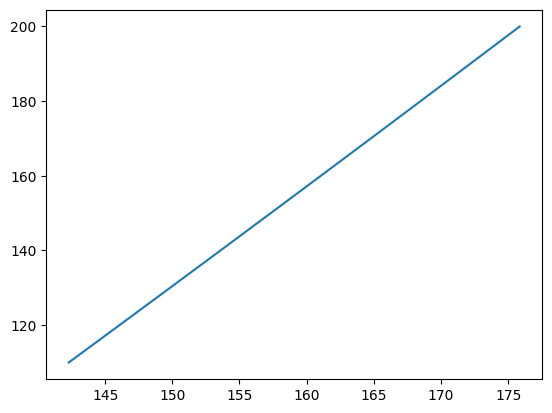

In [4]:
x_ohm = np.array([142.293, 146.068, 149.832, 153.584, 157.325, 161.054, 164.772, 168.478, 172.173, 175.856])
y_ohm = np.array([110, 120, 130, 140, 150, 160, 170, 180, 190, 200])

plt.plot(x_ohm,y_ohm)

In [5]:
from lmfit.models import LinearModel
mod = LinearModel() # Model(model_func_pos) + Model(model_func_neg)

pars = mod.make_params()
pars

name,value,initial value,min,max,vary
slope,1.00000000,None,-inf,inf,True
intercept,0.00000000,None,-inf,inf,True


In [6]:
result = mod.fit(y_ohm, pars, x=x_ohm)
result

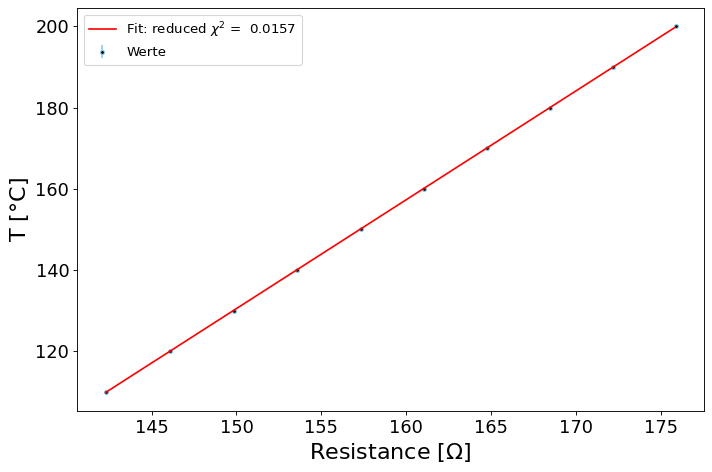

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/T_ohm_Fit.pdf} 
	\caption{T_ohm, Fit} 
 	\label{fig:T_ohm, Fit} 
\end{figure}


In [7]:
finish(x_ohm,y_ohm,result, "T_ohm", 0, r"T [$ \degree $C]", r"Resistance [$ \Omega $]")

## Fit-Funktionen festlegen

In [8]:
import numpy as np
import scipy.special
from scipy import signal
import lmfit
import matplotlib.pyplot as plt

# Your existing function definitions
def B(I):
    return (0.62941*I+0.14196*I**2-0.10654*I**3)*10**-3

def dB(I):
    return 174.42 * B(I)

def T_ohm(Ohm):
    return 2.68146897 * Ohm -271.738357 + 273.15

def R(x: np.ndarray):
    # amplitude, sigma, center, gamma = 142.3363574064359, 0.054160510030471176, 2.943447713559997, 0.054160510030471176
    # z = (x - center + gamma * 1j) / (np.sqrt(2) * sigma)
    # y = (amplitude * np.real(np.exp(-z**2) * scipy.special.erfc(-1j * z))) / (np.sqrt(2) * np.pi * sigma)
    # return y
    
    # amplitude	173.879031	5.52762602	(3.18%)	170.0	-inf	inf	True	
    # center	2.94377510	0.00410440	(0.14%)	3.0	-inf	inf	True	
    # sigma	0.09791620	0.00915807	(9.35%)	0.1	0.00000000	inf	True	
    # fraction	1.00000000	0.17571078	(17.57%)	0.5	0.00000000	1.00000000	True	
    Amp, mu, sigma, alpha = 173.879031, 2.94377510, 0.09791620, 1.00000000
    sigma_g = sigma/(np.sqrt(2*np.log(2)))
    return (1-alpha)*Amp/(sigma_g*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma_g**2)) + alpha*Amp/np.pi*(sigma/((x-mu)**2+sigma**2)) 

def h_pos(z, g):
    I_Amp = 0.506  # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 8.617333262e-5 #eV 1.380649e-23 J
    Ohm = 166 # pt100 Widerstand 
    mu_b = 5.7883818060e-5#eV 9.2740100783e-24 J
    z_0 = +1 / 2 * mu_b * dB(I_Amp) * g * d1 * (d2 + d1 / 2) / (k * T_ohm(Ohm) ) *10000
    a = z / z_0
    h = 1 / (a**3) * np.exp(-1 / a)
    h[z <= 0] = 0
    return h
    #return 1 / (a**3) * np.exp(-1 / a)

def h_neg(z, g):
    I_Amp = 0.506  # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 8.617333262e-5 #eV 1.380649e-23 J
    Ohm = 166 # pt100 Widerstand 
    mu_b = 5.7883818060e-5#eV 9.2740100783e-24 J
    z_0 = -1 / 2 * mu_b * dB(I_Amp) * g * d1 * (d2 + d1 / 2) / (k * T_ohm(Ohm) ) *10000
    a = z / z_0
    h = 1 / (a**3) * np.exp(-1 / a)
    h[z >= 0] = 0
    return h
    
    #return 1 / (a**3) * np.exp(-1 / a)

# Convolution function
def convolve_R_h_pos(x, g):
    # Evaluate R on the same grid as x
    R_values = R(x)
    R_values = R_values / np.abs(np.sum(R_values))
    center = 2.94377510
    # Evaluate h_pos on the same grid, using g as parameter
    try:
        h_values = h_pos(x-center, g)
        
        # Normalize h_values to preserve the amplitude after convolution
        if np.sum(h_values) != 0:
            h_values = np.abs(h_values / np.sum(h_values))
        
        # Perform the convolution
        convolution = signal.convolve(R_values, h_values, mode='same')
        return convolution
    except:
        # Handle potential numerical issues
        return np.zeros_like(x)

def convolve_R_h_neg(x, g):
    # Evaluate R on the same grid as x
    R_values = R(x)
    R_values = R_values / np.abs(np.sum(R_values))
    center = 2.94377510
    # Evaluate h_neg on the same grid, using g as parameter
    try:
        h_values = h_neg(x-center, g)
        
        # Normalize h_values to preserve the amplitude after convolution
        if np.sum(h_values) != 0:
            h_values = h_values / np.abs(np.sum(h_values))
        
        # Perform the convolution
        convolution = signal.convolve(R_values, h_values, mode='same')
        
        return convolution
    except:
        # Handle potential numerical issues
        return np.zeros_like(x)

In [43]:
I_Amp = 0.506  # Stromstärke Magnet
d1 = 10.16e-2
d2 = 60.66e-2 - d1
k = 8.617333262e-5 #eV 1.380649e-23 J
Ohm = 166 # pt100 Widerstand 
mu_b = 5.7883818060e-5#eV 9.2740100783e-24 J
g = 2
z_0 = +1 / 2 * mu_b * dB(I_Amp) * g * d1 * (d2 + d1 / 2) / (k * T_ohm(Ohm) )
z_0

5.052703831855389e-06

C:\Users\tlock\AppData\Local\Temp\ipykernel_19756\2826989534.py:10: RuntimeWarning: overflow encountered in exp
  h = 1 / (a**3) * np.exp(-1 / a)
C:\Users\tlock\AppData\Local\Temp\ipykernel_19756\2826989534.py:10: RuntimeWarning: overflow encountered in multiply
  h = 1 / (a**3) * np.exp(-1 / a)


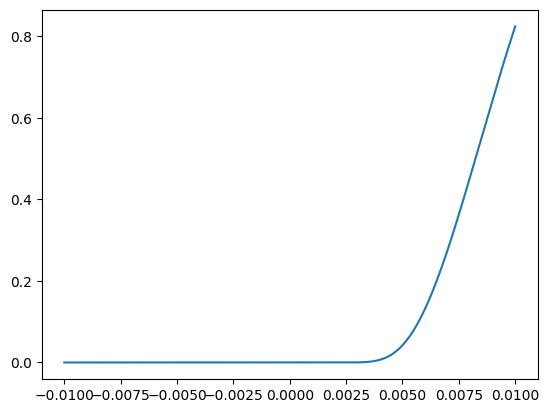

In [21]:
def h_pos(z, g):
    I_Amp = 0.506  # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 1.380649e-23
    Ohm = 166 # pt100 Widerstand 
    mu_b = 9.2740100783e-24
    z_0 = +1 / 2 * mu_b * dB(I_Amp) * g * d1 * (d2 + d1 / 2) / (k * T_ohm(Ohm) ) *10000
    a = z / z_0
    h = 1 / (a**3) * np.exp(-1 / a)
    h[z <= 0] = 0
    return h

def h_neg(z, g):
    I_Amp = 0.506  # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 1.380649e-23
    Ohm = 166 # pt100 Widerstand 
    mu_b = 9.2740100783e-24
    z_0 = -1 / 2 * mu_b * dB(I_Amp) * g * d1 * (d2 + d1 / 2) / (k * T_ohm(Ohm) ) *10000
    a = z / z_0
    h = 1 / (a**3) * np.exp(-1 / a)
    h[z >= 0] = 0
    return h

resolution_array = np.arange(-0.01, 0.01, 0.0000001)
plt.plot(resolution_array, h_pos(resolution_array, 2))

#plt.xlim(2.942, 2.9445)
# plt.ylim(-0.001, 0.0025)

C:\Users\tlock\AppData\Local\Temp\ipykernel_12656\2534117315.py:54: RuntimeWarning: overflow encountered in exp
  h = 1 / (a**3) * np.exp(-1 / a)
C:\Users\tlock\AppData\Local\Temp\ipykernel_12656\2534117315.py:54: RuntimeWarning: overflow encountered in multiply
  h = 1 / (a**3) * np.exp(-1 / a)
C:\Users\tlock\AppData\Local\Temp\ipykernel_12656\2534117315.py:40: RuntimeWarning: overflow encountered in exp
  h = 1 / (a**3) * np.exp(-1 / a)


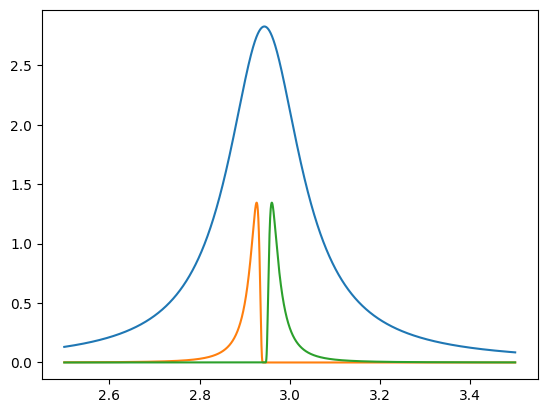

In [9]:
resolution_array = np.arange(2.5, 3.5, 0.00001)
plt.plot(resolution_array, R(resolution_array)/200)
center = 2.943447713559997
plt.plot(resolution_array, h_neg(resolution_array- center, 2))
plt.plot(resolution_array, h_pos(resolution_array- center, 2))
# plt.xlim(2.942, 2.9445)
# plt.ylim(-0.001, 0.0025)

C:\Users\tlock\AppData\Local\Temp\ipykernel_12656\2534117315.py:40: RuntimeWarning: overflow encountered in exp
  h = 1 / (a**3) * np.exp(-1 / a)
C:\Users\tlock\AppData\Local\Temp\ipykernel_12656\2534117315.py:40: RuntimeWarning: overflow encountered in multiply
  h = 1 / (a**3) * np.exp(-1 / a)
C:\Users\tlock\AppData\Local\Temp\ipykernel_12656\2534117315.py:54: RuntimeWarning: overflow encountered in exp
  h = 1 / (a**3) * np.exp(-1 / a)
C:\Users\tlock\AppData\Local\Temp\ipykernel_12656\2534117315.py:54: RuntimeWarning: overflow encountered in multiply
  h = 1 / (a**3) * np.exp(-1 / a)


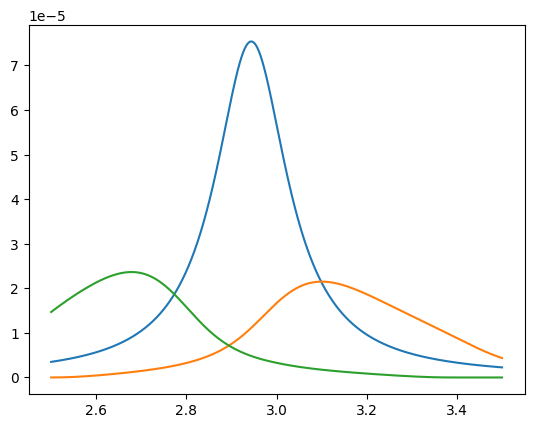

In [10]:
plt.plot(resolution_array, R(resolution_array)/7500000)
plt.plot(resolution_array, convolve_R_h_pos(resolution_array, 20))
#plt.plot(resolution_array, convolve_R_h_pos(resolution_array, 10))
plt.plot(resolution_array, convolve_R_h_neg(resolution_array, 20))


In [12]:
def plot_func(x, g=2, amplitude=200000):
    return convolve_R_h_pos(x, g)*amplitude
def plot_func_0(x, g=2, amplitude=200000):
    return convolve_R_h_neg(x, g)*amplitude

def fit_func(x, g = 30, amp = 2500000):
    return plot_func(x,g,amp) + plot_func_0(x,g,amp)

<ErrorbarContainer object of 3 artists>

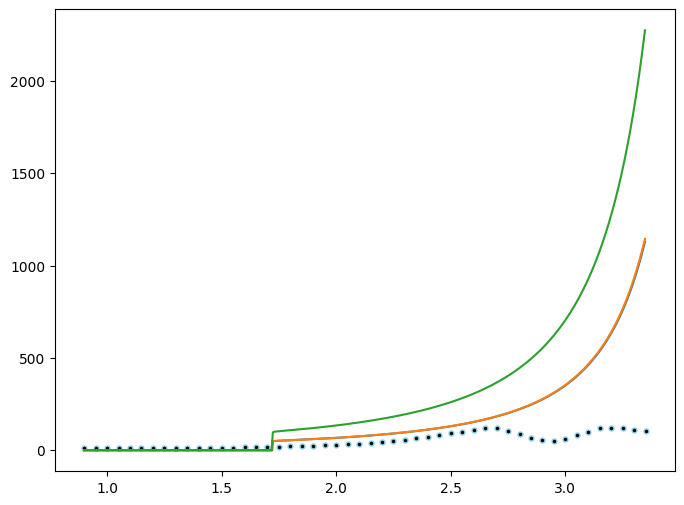

In [ ]:
resolution_array = np.arange(np.min(Daten.get_x()), np.max(Daten.get_x()), (np.max(Daten.get_x()) - np.min(Daten.get_x()))/1000 )

plt.figure(figsize=(8, 6))
plt.plot(resolution_array, plot_func(resolution_array, 30, 2500000))
plt.plot(resolution_array, plot_func_0(resolution_array, 30, 2500000))
plt.plot(resolution_array, fit_func(resolution_array, 2, 2500000))
plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
    fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
    label = r'Werte')

# Fitten

C:\Users\tlock\AppData\Local\Temp\ipykernel_12656\2534117315.py:40: RuntimeWarning: overflow encountered in exp
  h = 1 / (a**3) * np.exp(-1 / a)
C:\Users\tlock\AppData\Local\Temp\ipykernel_12656\2534117315.py:54: RuntimeWarning: overflow encountered in exp
  h = 1 / (a**3) * np.exp(-1 / a)


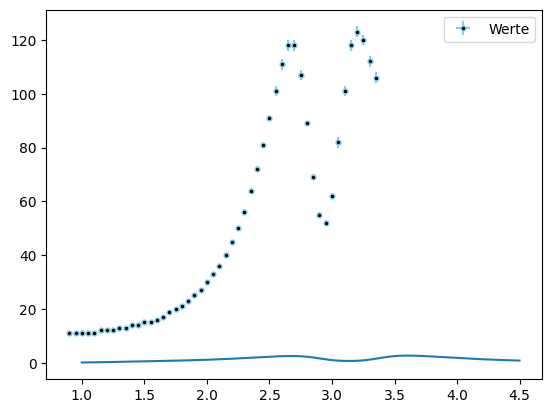

In [50]:
resolution_array = np.arange(1, 4.5, 0.001)
plt.plot(resolution_array, fit_func(resolution_array, 50 , 2500))
# plt.plot(resolution_array, plot_func(resolution_array, 40, 2500),label="convolution_pos")
# plt.plot(resolution_array, plot_func_0(resolution_array, 40, 2500
#                                        ),label="convolution")
plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
    fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
    label = r'Werte')
# plt.plot(resolution_array, R(resolution_array), label="R(z)")

# plt.plot(resolution_array, convolve_R_h_pos(resolution_array, 20)*120, label="h_pos(z)")
# #plt.plot(resolution_array, convolve_R_h_pos(resolution_array, 10))
# plt.plot(resolution_array, convolve_R_h_neg(resolution_array, 20)*120, label="h_neg(z)")
plt.legend()

In [31]:
from lmfit.models import PowerLawModel, ExponentialModel, GaussianModel, Model, LinearModel

# import pylandau

# def plot_func(x, mpv=1, eta=1, sigma=1, A=1):
#     return pylandau.langau(x, mpv, eta, sigma, A)

# def plot_func(x,g = 30, amplitude=7000, center = 2.5):
#    return convolve_R_h_pos(x, g, center) * amplitude + convolve_R_h_neg(x, g, center) * amplitude


# x, g, g_= symbols("x, g, g_")

# mod = Model(lambdify((x,g), integral_pos)) + Model(lambdify((x,g_), integral_neg))

Daten.set_func(plot_func)
mod = Model(fit_func) #+ LinearModel() # Model(model_func_pos) + Model(model_func_neg)

pars = mod.make_params()
pars


name,value,initial value,min,max,vary
g,30.0000000,None,-inf,inf,True
amp,2500000.00,None,-inf,inf,True


In [235]:
pars["g"].set(min = 1)
pars["g"].set(max = 50)
pars
# pars["g_"].set(min = 0)
# pars["g_"].set(max = 3)

name,value,initial value,min,max,vary
g,30.0000000,None,1.00000000,50.0000000,True
amplitude,7000.00000,None,-inf,inf,True
center,2.50000000,None,-inf,inf,True


## Parameter Festlegen

In [32]:
# Funktion zum Speichern der Parameter in einer JSON-Datei
def save_params_to_file(params, filename='params.json'):
    # Dictionary für Parameter-Werte erstellen
    params_dict = {name: param.value for name, param in params.items()}
    
    # Parameter als JSON-Datei speichern
    with open(filename, 'w') as f:
        json.dump(params_dict, f)
    print(f"Parameter wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_params_from_file(params, filename='params.json'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'r') as f:
        params_dict = json.load(f)

    # Geladene Werte in die Parameter setzen
    for name, value in params_dict.items():
        if name in params:
            params[name].value = value
        else:
            print(f"Warnung: Parameter {name} existiert nicht im aktuellen Modell.")

    print(f"Parameter wurden aus {filename} geladen.")

def update_model(Save:int=0, Load:int=0, **params):
    # Setze die Werte der Parameter
    for name, value in params.items():
        pars[name].value = value
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_params_to_file(pars, f'{Daten.get_FileName()}_params_{Save}.json')
        Daten.set_Version(Save)
    if Load != 0:
        load_params_from_file(pars, f'{Daten.get_FileName()}_params_{Load}.json')
        Daten.set_Version(Load)

    # Berechne Modell mit aktuellen Parametern
    x = Daten.get_x()
    x_fit = np.arange(x.min(), x.max(), (x.max() - x.min())/10000)
    y_fit = mod.eval(pars, x=x_fit)

    # Plotten der Daten und des Modells
    plt.figure(figsize=(8, 6))
    plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
        label = r'Werte')
    
    plt.plot(x_fit, y_fit, label="Modell", color='red')
    plt.legend()
    plt.ylabel(Daten.get_YName(), fontsize=20)
    plt.xlabel(Daten.get_XName(), fontsize=20)
    plt.title('Models')
    result = mod.fit(Daten.get_y(), pars, x=Daten.get_x())
    Daten.set_pars(result)
    dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'b-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.tight_layout()
    plt.show()
    

interactive(children=(IntText(value=0, description='Save'), IntText(value=0, description='Load'), FloatText(va…

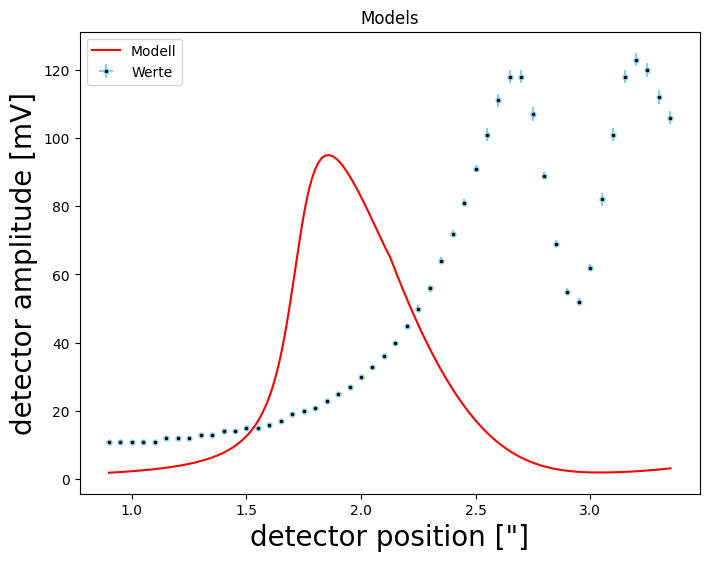

In [ ]:
param_widgets = {}
for param_name, param in pars.items():
    param_widgets[param_name] = FloatText(value=param.value,
                                            step=0.1,
                                            description=param_name)

# Interaktive Anzeige mit automatisch generierten Slidern
interact(update_model, Save=IntText(value=0), Load=IntText(value=0), **param_widgets)
print()

In [239]:
pars

name,value,initial value,min,max,vary
g,30.0000000,None,1.00000000,50.0000000,True
amplitude,7000.00000,None,-inf,inf,True
center,2.50000000,None,-inf,inf,True


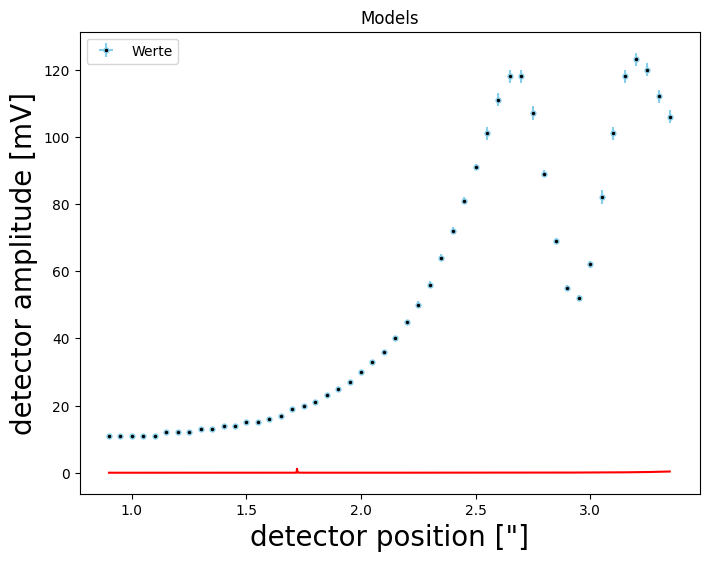

In [52]:
result = mod.fit(Daten.get_y(), pars, x=Daten.get_x(), nan_policy="omit")
dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))

plt.figure(figsize=(8, 6))
plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
    fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
    label = r'Werte')

#plt.plot(x_fit, y_fit, label="Modell", color='red')
plt.legend()
plt.ylabel(Daten.get_YName(), fontsize=20)
plt.xlabel(Daten.get_XName(), fontsize=20)
plt.title('Models')

plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))

plt.show()

In [53]:
result

In [37]:
Daten.get_pars()

C:\Users\tlock\AppData\Local\Temp\ipykernel_18912\2553003439.py:1: RuntimeWarning: divide by zero encountered in divide
  weights = 1/np.sqrt(Daten.get_y())


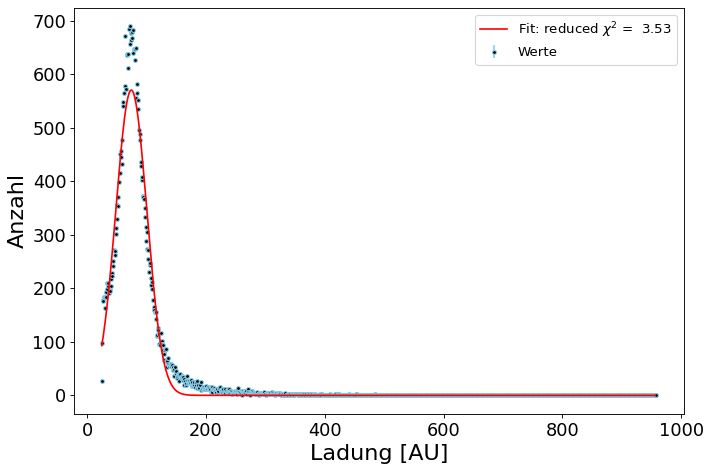

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/A4_V20.h5_charge.txt_Fit.pdf} 
	\caption{A4_V20.h5_charge.txt, Fit} 
 	\label{fig:A4_V20.h5_charge.txt, Fit} 
\end{figure}


In [17]:
weights = 1/np.sqrt(Daten.get_y())
weights[weights == np.inf] = 0
Daten.set_yerr(weights)

result = mod.fit(Daten.get_y(), pars, x=Daten.get_x(), weights = weights)
finish(Daten.get_x(),Daten.get_y(),result, Daten.get_FileName(), Daten.get_yerr(), Daten.get_YName(), Daten.get_XName())

In [ ]:
def h_pos(z, g):
    I_Amp = 0.506  # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 8.617333262e-5 #eV 1.380649e-23 J
    Ohm = 166 # pt100 Widerstand 
    mu_b = 5.7883818060e-5#eV 9.2740100783e-24 J
    z_0 = +1 / 2 * mu_b * dB(I_Amp) * g * d1 * (d2 + d1 / 2) / (k * T_ohm(Ohm) ) *10000
    a = z / z_0
    h = 1 / (a**3) * np.exp(-1 / a)
    h[z <= 0] = 0
    return h
    #return 1 / (a**3) * np.exp(-1 / a)

def h_neg(z, g):
    I_Amp = 0.506  # Stromstärke Magnet
    d1 = 10.16e-2
    d2 = 60.66e-2 - d1
    k = 8.617333262e-5 #eV 1.380649e-23 J
    Ohm = 166 # pt100 Widerstand 
    mu_b = 5.7883818060e-5#eV 9.2740100783e-24 J
    z_0 = -1 / 2 * mu_b * dB(I_Amp) * g * d1 * (d2 + d1 / 2) / (k * T_ohm(Ohm) ) *10000
    a = z / z_0
    h = 1 / (a**3) * np.exp(-1 / a)
    h[z >= 0] = 0
    return h

SyntaxError: invalid syntax. Perhaps you forgot a comma? (491136534.py, line 4)

In [231]:
I_Amp = 0.506  # Stromstärke Magnet
d1 = 10.16e-2
d2 = 60.66e-2 - d1
k = 8.617333262e-5 #eV 1.380649e-23 J
Ohm = 166 # pt100 Widerstand 
mu_b = 5.7883818060e-5#eV 9.2740100783e-24 J

z_0 = 2.6
g = z_0 / (-1 / 2 * mu_b * dB(I_Amp) * d1 * (d2 + d1 / 2) / (k * T_ohm(Ohm) ))
g_alt = np.abs(24*z_0*k*T_ohm(Ohm)/(mu_b*dB(I_Amp)*d1*(d1+2*d2)))
g, g_alt

(-1029151.949737478, 6174911.698424868)